In [1]:
from datetime import datetime
import threading
from typing import Dict
import os
import easybar
import shutil
import pickle
import time

from catalyst import dl, metrics, utils
from catalyst.data import BatchPrefetchLoaderWrapper
from catalyst.data.sampler import DistributedSamplerWrapper
from catalyst.dl import DataParallelEngine, DistributedDataParallelEngine
from catalyst.data.loader import ILoaderWrapper

import ipdb
import nibabel as nib
import numpy as np
from pymongo.errors import OperationFailure

import torch
from torch.optim.lr_scheduler import (
    MultiStepLR,
    OneCycleLR,
    CosineAnnealingLR,
    ChainedScheduler,
    CyclicLR,
    StepLR,
    ConstantLR,
)
from torch.utils.data import DataLoader, Dataset, DistributedSampler

from dice import faster_dice, DiceLoss
from meshnet import enMesh_checkpoint, enMesh
from mindfultensors.gencoords import CoordsGenerator
from mindfultensors.utils import (
    unit_interval_normalize,
    qnormalize,
    DBBatchSampler,
)

from mindfultensors.mongoloader import (
    create_client,
    collate_subcubes,
    mcollate,
    MongoDataset,
    MongoClient,
    mtransform,
)

# SEED = 0
# utils.set_global_seed(SEED)
# utils.prepare_cudnn(deterministic=False, benchmark=False) # crashes everything

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"
# os.environ["NCCL_SOCKET_IFNAME"] = "ib0"
# os.environ["NCCL_P2P_LEVEL"] = "NVL"

volume_shape = [256] * 3
MAXSHAPE = 300

LABELFIELD = "label"
DATAFIELD = "data"

n_classes = 18

MONGOHOST = "10.245.12.58"  # "arctrdcn018.rs.gsu.edu"
DBNAME = "babywire_test"
COLLECTION = "read"
INDEX_ID = "id"
config_file = "modelAE.json"


def merge_homologs(label, device):
    max_value = 31
    idx = torch.arange(max_value + 1, dtype=torch.long).to(device)
    idx[31] = 17
    idx[30] = 16
    idx[29] = 15
    idx[28] = 14
    idx[27] = 10
    idx[26] = 9
    idx[25] = 8
    idx[24] = 7
    idx[23] = 6
    idx[22] = 5
    idx[21] = 4
    idx[20] = 3
    idx[19] = 2
    idx[18] = 1
    # return the corresponding values from idx
    return idx[label.long()]


class WireMongoDataset(MongoDataset):
    def __init__(self, *args, keeptrying=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.keeptrying = keeptrying  # Initialize the keeptrying attribute

    def retry_on_eof_error(retry_count, verbose=False):
        def decorator(func):
            def wrapper(self, batch, *args, **kwargs):
                myException = Exception  # Default Exception if not overwritten
                for attempt in range(retry_count):
                    try:
                        return func(self, batch, *args, **kwargs)
                    except (
                        EOFError,
                        OperationFailure,
                    ) as e:  # Specifically catching EOFError
                        if self.keeptrying:
                            if verbose:
                                print(
                                    f"EOFError caught. Retrying {attempt+1}/{retry_count}"
                                )
                            time.sleep(1)
                            myException = e
                            continue
                        else:
                            raise e
                raise myException("Failed after multiple retries.")

            return wrapper

        return decorator

    @retry_on_eof_error(retry_count=3, verbose=True)
    def __getitem__(self, batch):
        # Directly use the parent class's __getitem__ method
        # The decorator will handle exceptions
        return super().__getitem__(batch)


# CustomRunner – PyTorch for-loop decomposition
# https://github.com/catalyst-team/catalyst#minimal-examples
class CustomRunner(dl.Runner):
    def __init__(
        self,
        logdir: str,
        wandb_project: str,
        wandb_experiment: str,
        model_path: str,
        n_channels: int,
        n_classes: int,
        n_epochs: int,
        optimize_inline: bool,        validation_percent: float,
        onecycle_lr: float,
        rmsprop_lr: float,
        num_subcubes: int,
        num_volumes: int,
        client_creator,
        off_brain_weight: float,
        prefetches=8,
        volume_shape=[256] * 3,
        subvolume_shape=[256] * 3,
        db_host=MONGOHOST,
        db_name=DBNAME,
        db_collection=COLLECTION,
    ):
        super().__init__()
        self._logdir = logdir
        self.wandb_project = wandb_project
        self.wandb_experiment = wandb_experiment
        self.model_path = model_path
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.optimize_inline = optimize_inline
        self.onecycle_lr = onecycle_lr
        self.rmsprop_lr = rmsprop_lr
        self.prefetches = prefetches
        self.db_host = db_host
        self.db_name = db_name
        self.db_collection = db_collection
        self.shape = subvolume_shape[0]
        self.num_subcubes = num_subcubes
        self.num_volumes = num_volumes
        self.n_epochs = n_epochs
        self.off_brain_weight = off_brain_weight
        self.client_creator = client_creator
        self.funcs = None
        self.collate = None

    def get_engine(self):
        if torch.cuda.device_count() > 1:
            return dl.DistributedDataParallelEngine(
                # mixed_precision='fp16',
                # ddp_kwargs={"find_unused_parameters": True, "backend": "nccl"}
                process_group_kwargs={"backend": "nccl"}
            )
        else:
            return dl.GPUEngine()

    def get_loggers(self):
        return {
            "console": dl.ConsoleLogger(),
            "csv": dl.CSVLogger(logdir=self._logdir),
            # "tensorboard": dl.TensorboardLogger(logdir=self._logdir,
            #                                     log_batch_metrics=True),
            "wandb": dl.WandbLogger(
                project=self.wandb_project,
                name=self.wandb_experiment,
                log_batch_metrics=True,
            ),
        }

    @property
    def stages(self):
        return ["train"]

    @property
    def num_epochs(self) -> int:
        return self.n_epochs

    @property
    def seed(self) -> int:
        """Experiment's seed for reproducibility."""
        random_data = os.urandom(4)
        SEED = int.from_bytes(random_data, byteorder="big")
        utils.set_global_seed(SEED)
        return SEED

    def get_stage_len(self) -> int:
        return self.n_epochs

    def get_loaders(self):
        self.funcs = {
            "createclient": self.client_creator.create_client,
            "mycollate": self.client_creator.mycollate,
            "mycollate_full": self.client_creator.mycollate_full,
            "mytransform": self.client_creator.mytransform,
        }

        self.collate = (
            self.funcs["mycollate_full"]
            if self.shape == 256
            else self.funcs["mycollate"]
        )

        client = MongoClient("mongodb://" + self.db_host + ":27017")
        db = client[self.db_name]
        posts = db[self.db_collection + ".bin"]
        num_examples = int(posts.find_one(sort=[(INDEX_ID, -1)])[INDEX_ID] + 1)

        tdataset = WireMongoDataset(
            range(num_examples),
            self.funcs["mytransform"],
            None,
            (DATAFIELD, LABELFIELD),
            normalize=qnormalize,
            id=INDEX_ID,
        )

        tsampler = (
            DistributedSamplerWrapper(
                DBBatchSampler(tdataset, batch_size=self.num_volumes)
            )
            if self.engine.is_ddp
            else DBBatchSampler(tdataset, batch_size=self.num_volumes)
        )

        tdataloader = BatchPrefetchLoaderWrapper(
            DataLoader(
                tdataset,
                sampler=tsampler,
                collate_fn=self.collate,
                pin_memory=True,
                worker_init_fn=self.funcs["createclient"],
                persistent_workers=True,
                prefetch_factor=3,
                num_workers=self.prefetches,
            ),
            num_prefetches=self.prefetches,
        )

        return {"train": tdataloader}

    def get_model(self):
        if self.shape > MAXSHAPE:
            model = enMesh(
                in_channels=1,
                n_classes=self.n_classes,
                channels=self.n_channels,
                config_file=config_file,
                optimize_inline=self.optimize_inline,
            )
        else:
            model = enMesh_checkpoint(
                in_channels=1,
                n_classes=self.n_classes,
                channels=self.n_channels,
                config_file=config_file,
            )
        return model

    def get_criterion(self):
        class_weight = torch.FloatTensor(
            [self.off_brain_weight] + [1.0] * (self.n_classes - 1)
        ).to(self.engine.device)
        ce_criterion = torch.nn.CrossEntropyLoss(
            weight=class_weight, label_smoothing=0.01
        )
        dice_criterion = DiceLoss()

        def combined_loss(output, target):
            ce_loss = ce_criterion(output, target)
            dice_loss = dice_criterion(output, target)
            return 0.7 * ce_loss + 0.3 * dice_loss

        return combined_loss

    def get_criterion_(self):
        class_weight = torch.FloatTensor(
            [self.off_brain_weight] + [1.0] * (self.n_classes - 1)
        ).to(self.engine.device)
        criterion = torch.nn.CrossEntropyLoss(
            weight=class_weight, label_smoothing=0.01
        )
        # criterion = DiceLoss()
        return criterion

    def get_optimizer(self, model):
        # optimizer = torch.optim.RMSprop(model.parameters(), lr=self.rmsprop_lr)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.rmsprop_lr)
        return optimizer

    def get_scheduler(self, optimizer):
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.onecycle_lr,
            div_factor=100,
            pct_start=0.2,
            epochs=self.num_epochs,
            steps_per_epoch=len(self.loaders["train"]),
        )
        return scheduler

    def get_callbacks(self):
        checkpoint_params = {"save_best": True, "metric_key": "macro_dice"}
        if self.model_path:
            checkpoint_params.update({"resume_model": self.model_path})
        return {
            "checkpoint": dl.CheckpointCallback(
                self._logdir, **checkpoint_params
            ),
            "tqdm": dl.TqdmCallback(),
        }

    def on_loader_start(self, runner):
        """
        Calls runner methods when the dataloader begins and adds
        metrics for loss and macro_dice
        """
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveValueMetric(compute_on_call=False)
            for key in ["loss", "macro_dice", "learning rate"]
        }

    def on_loader_end(self, runner):
        """
        Calls runner methods when a dataloader finishes running and updates
        metrics
        """
        for key in ["loss", "macro_dice", "learning rate"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

    # model train/valid step
    def handle_batch(self, batch):
        # unpack the batch
        sample, label = batch
        label = merge_homologs(label, self.engine.device)
        y_hat = self.model.forward(sample)
        np.save("test_label.npy", label.cpu().numpy())
        np.save("test_input.npy", sample.detach().cpu().numpy())
        np.save("test_output.npy", y_hat.detach().cpu().numpy())

class ClientCreator:
    def __init__(self, dbname, mongohost, volume_shape=[256] * 3):
        self.dbname = dbname
        self.mongohost = mongohost
        self.volume_shape = volume_shape
        self.subvolume_shape = None
        self.collection = None
        self.num_subcubes = None

    def set_shape(self, shape):
        self.subvolume_shape = shape
        self.coord_generator = CoordsGenerator(
            self.volume_shape, self.subvolume_shape
        )

    def set_collection(self, collection):
        self.collection = collection

    def set_num_subcubes(self, num_subcubes):
        self.num_subcubes = num_subcubes

    def create_client(self, x):
        return create_client(
            x,
            dbname=self.dbname,
            colname=self.collection,
            mongohost=self.mongohost,
        )

    def mycollate(self, x):
        return collate_subcubes(
            x,
            self.coord_generator,
            samples=self.num_subcubes,
        )

    def mycollate_full(self, x):
        return mcollate(x)

    def mytransform(self, x):
        return mtransform(x)


def assert_equal_length(*args):
    assert all(
        len(arg) == len(args[0]) for arg in args
    ), "Not all parameter lists have the same length!"


if __name__ == "__main__":
    # hparams
    validation_percent = 0.1
    optimize_inline = False

    model_channels = 30
    model_label = "_ss"

    model_path = f"./logs/tmp/curriculum_enmesh_{model_channels}channels_ss/model.last.pth"
    #model_path = ""
    logdir = f"./logs/tmp/curriculum_enmesh_{model_channels}channels_ss/"
    wandb_project = f"curriculum_{model_channels}_ss"

    client_creator = ClientCreator(DBNAME, MONGOHOST)

    # set up parameters of your experiment
    experiment_count = 1

    cubesizes   = [256] * experiment_count
    numcubes    = [4] * experiment_count
    numvolumes  = [1] * experiment_count
    weights     = [1] * experiment_count  # weights for the 0-class
    collections = ["read"] * experiment_count
    epochs      = [1] * experiment_count
    prefetches  = [1] * experiment_count
    attenuates  = [1] * experiment_count

    assert_equal_length(
        cubesizes,
        numcubes,
        numvolumes,
        weights,
        collections,
        epochs,
        prefetches,
        attenuates,
    )

    start_experiment = 0
    for experiment in range(len(cubesizes)):
        COLLECTION = collections[experiment]
        num_subcubes = numcubes[experiment]
        num_volumes = numvolumes[experiment]

        off_brain_weight = weights[experiment]
        subvolume_shape = [cubesizes[experiment]] * 3
        onecycle_lr = rmsprop_lr = (
            attenuates[experiment] * 0.05 * 8 * num_subcubes * num_volumes / 256
        )
        n_epochs = epochs[experiment]
        n_fetch = prefetches[experiment]
        wandb_experiment = (
            f"{start_experiment + experiment:02} cube "
            + str(subvolume_shape[0])
            + " "
            + COLLECTION
            + model_label
        )

        # Set database parameters
        client_creator.set_collection(COLLECTION)
        client_creator.set_num_subcubes(num_subcubes)
        client_creator.set_shape(subvolume_shape)

        runner = CustomRunner(
            logdir=logdir,
            wandb_project=wandb_project,
            wandb_experiment=wandb_experiment,
            model_path=model_path,
            n_channels=model_channels,
            n_classes=n_classes,
            n_epochs=n_epochs,
            optimize_inline=optimize_inline,
            validation_percent=validation_percent,
            onecycle_lr=onecycle_lr,
            rmsprop_lr=rmsprop_lr,
            num_subcubes=num_subcubes,
            num_volumes=num_volumes,
            client_creator=client_creator,
            off_brain_weight=off_brain_weight,
            prefetches=n_fetch,
            db_collection=COLLECTION,
            subvolume_shape=subvolume_shape,
        )
        runner.run()

/data/users1/mdoan4/anaconda3/envs/wirehead_train/lib/python3.9/site-packages/catalyst/loggers/wandb.py:77: UserWarning: Wandb does NOT support several x-axes for logging.For this reason, everything has to be logged in the batch-based regime.
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: spikedoanz. Use `wandb login --relogin` to force relogin


/data/users1/mdoan4/anaconda3/envs/wirehead_train/lib/python3.9/site-packages/catalyst/core/misc.py:119: UserWarning: No ``ICriterionCallback/CriterionCallback`` were found while runner.criterion is not None.Do you compute the loss during ``runner.handle_batch``?
  warnings.warn(
/data/users1/mdoan4/anaconda3/envs/wirehead_train/lib/python3.9/site-packages/catalyst/core/misc.py:127: UserWarning: No ``IBackwardCallback/BackwardCallback`` were found while runner.criterion/optimizer is not None.Do you backward the loss during ``runner.handle_batch``?
  warnings.warn(
/data/users1/mdoan4/anaconda3/envs/wirehead_train/lib/python3.9/site-packages/catalyst/core/misc.py:133: UserWarning: No ``IOptimizerCallback/OptimizerCallback`` were found while runner.optimizer is not None.Do run optimisation step pass during ``runner.handle_batch``?
  warnings.warn(
/data/users1/mdoan4/anaconda3/envs/wirehead_train/lib/python3.9/site-packages/catalyst/core/misc.py:139: UserWarning: No ``ISchedulerCallback/

Keyboard Interrupt


KeyboardInterrupt: 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot(tensor, slice_dim=0, cmap='viridis', crop_percentile=10):
    # Create a copy of the tensor to avoid modifying the original
    data_for_processing = tensor.copy()

    # Thresholding (assuming background has very low values compared to the head)
    threshold = np.percentile(data_for_processing, crop_percentile)
    data_for_processing[data_for_processing < threshold] = 0

    # Find the bounding box around the head (non-zero region) in the filtered data
    indices = np.nonzero(data_for_processing)
    min_z, max_z = np.min(indices[0]), np.max(indices[0])
    min_y, max_y = np.min(indices[1]), np.max(indices[1])
    min_x, max_x = np.min(indices[2]), np.max(indices[2])

    # Crop the original tensor using the bounding box from the filtered data
    cropped_tensor = tensor[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1]

    # Determine the dimensions of the cropped tensor
    dim0, dim1, dim2 = cropped_tensor.shape

    # Determine the slicing dimensions based on the specified slice_dim
    if slice_dim == 0:
        num_slices = dim0
        slice_shape = (dim1, dim2)
    elif slice_dim == 1:
        num_slices = dim1
        slice_shape = (dim0, dim2)
    elif slice_dim == 2:
        num_slices = dim2
        slice_shape = (dim0, dim1)
    else:
        raise ValueError("Invalid slice_dim. Must be 0, 1, or 2.")

    # Calculate the grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_slices)))

    # Create a larger matrix to hold the slices
    R = np.zeros((grid_size * slice_shape[0], grid_size * slice_shape[1]))

    # Iterate over the slices and place them in the larger matrix
    for i in range(grid_size):
        for j in range(grid_size):
            slice_index = i * grid_size + j
            if slice_index < num_slices:
                if slice_dim == 0:
                    slice_data = cropped_tensor[slice_index, :, :]
                elif slice_dim == 1:
                    slice_data = cropped_tensor[:, slice_index, :]
                else:  # slice_dim == 2
                    slice_data = cropped_tensor[:, :, slice_index]
                R[i*slice_shape[0]:(i+1)*slice_shape[0], j*slice_shape[1]:(j+1)*slice_shape[1]] = slice_data

    # Plot the larger matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(R, cmap=cmap)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

(18, 256, 256, 256)


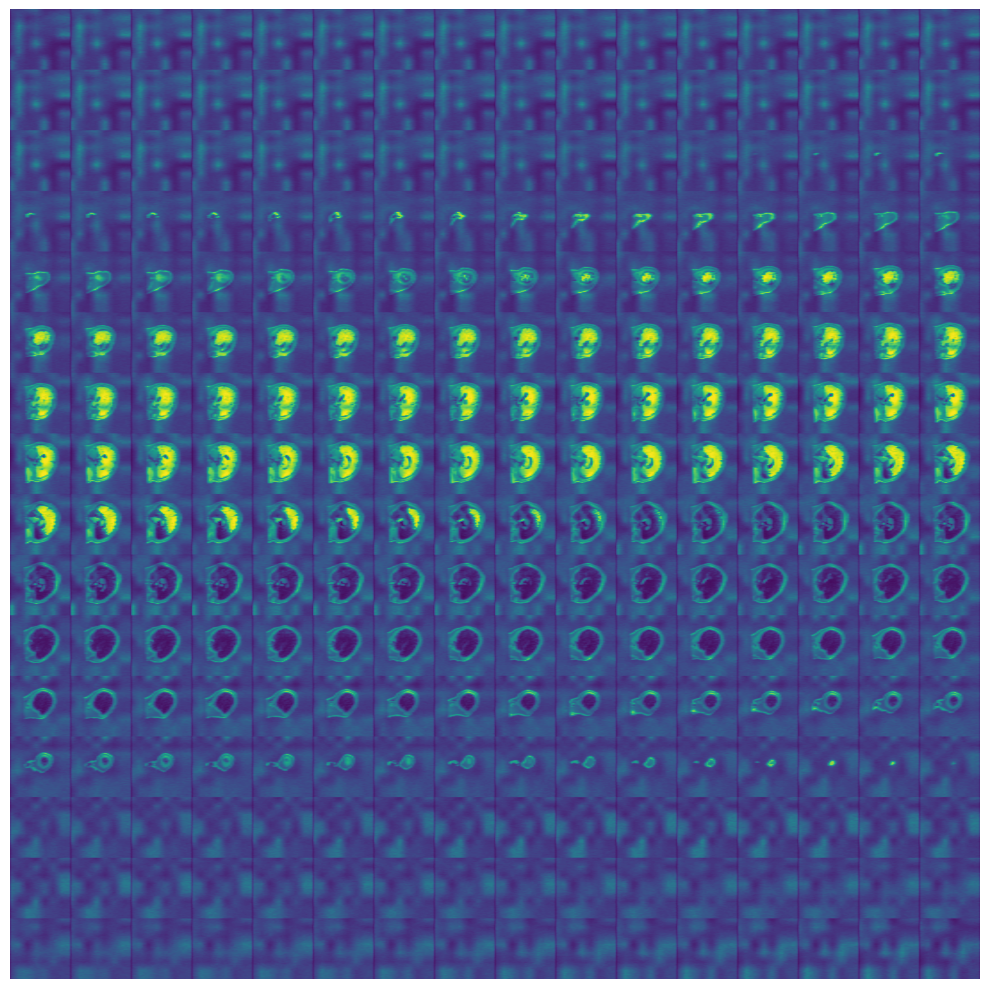

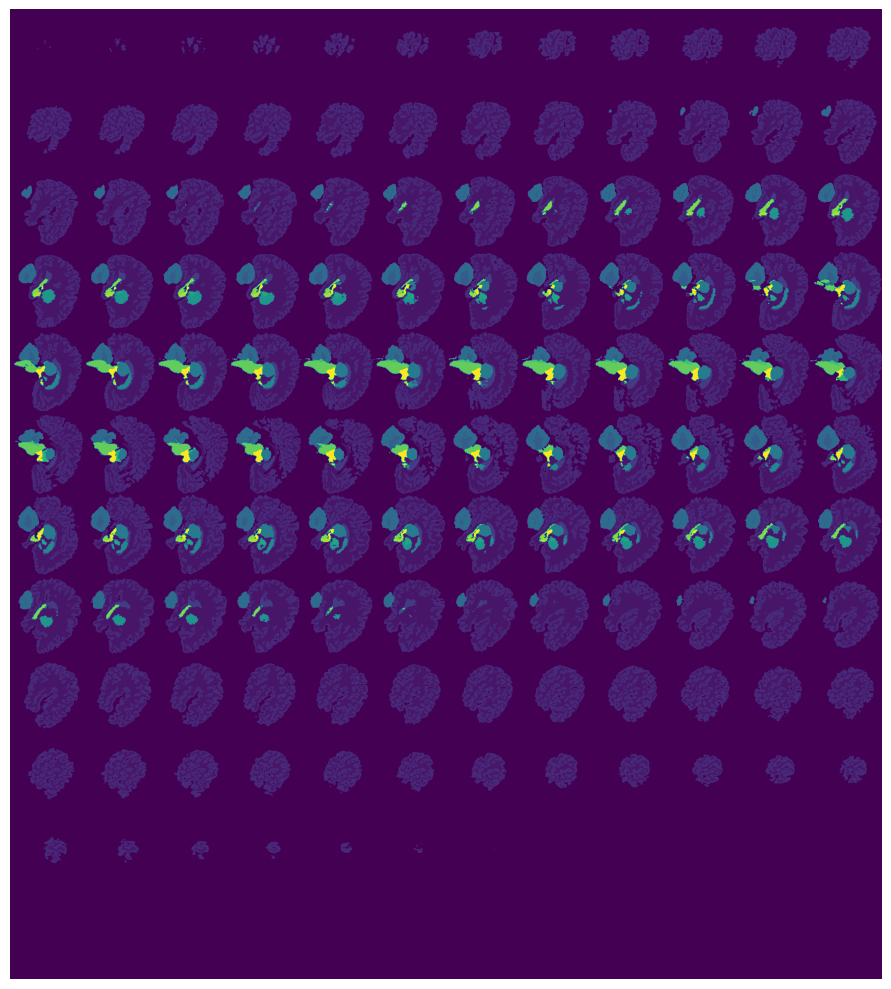

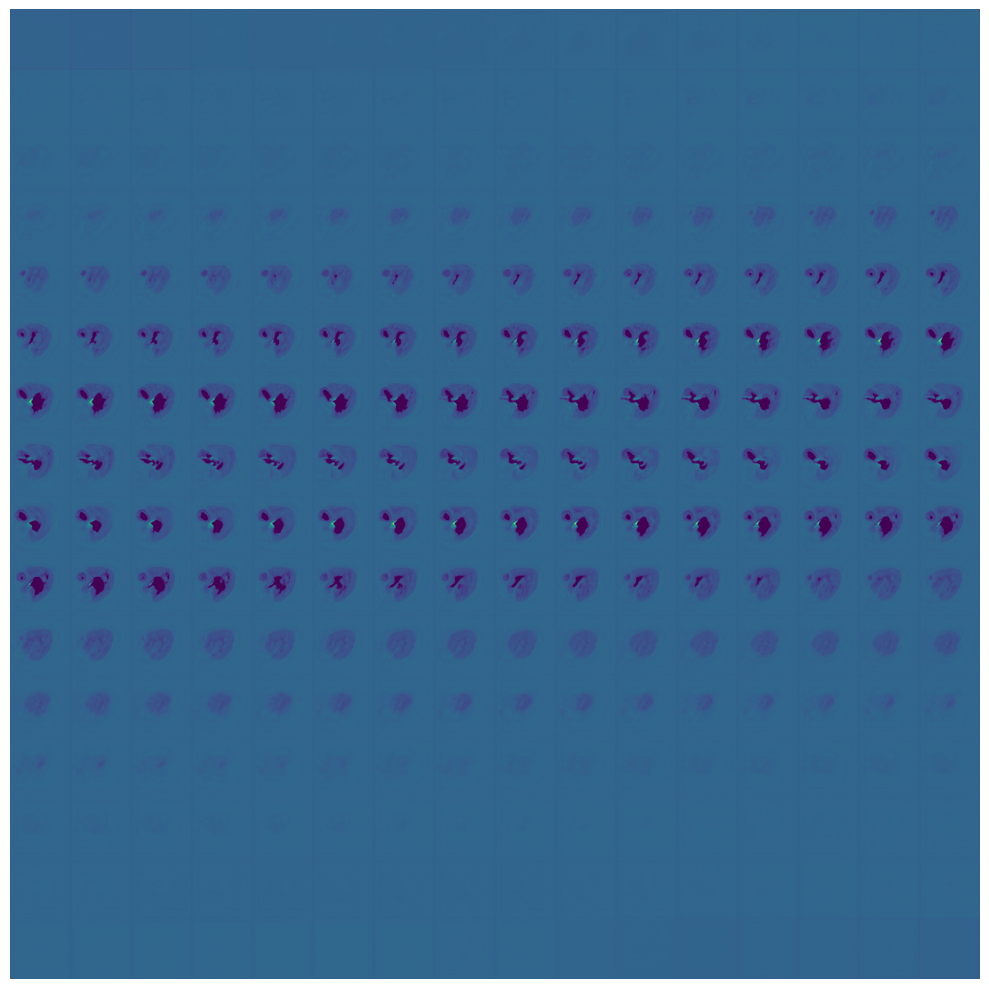

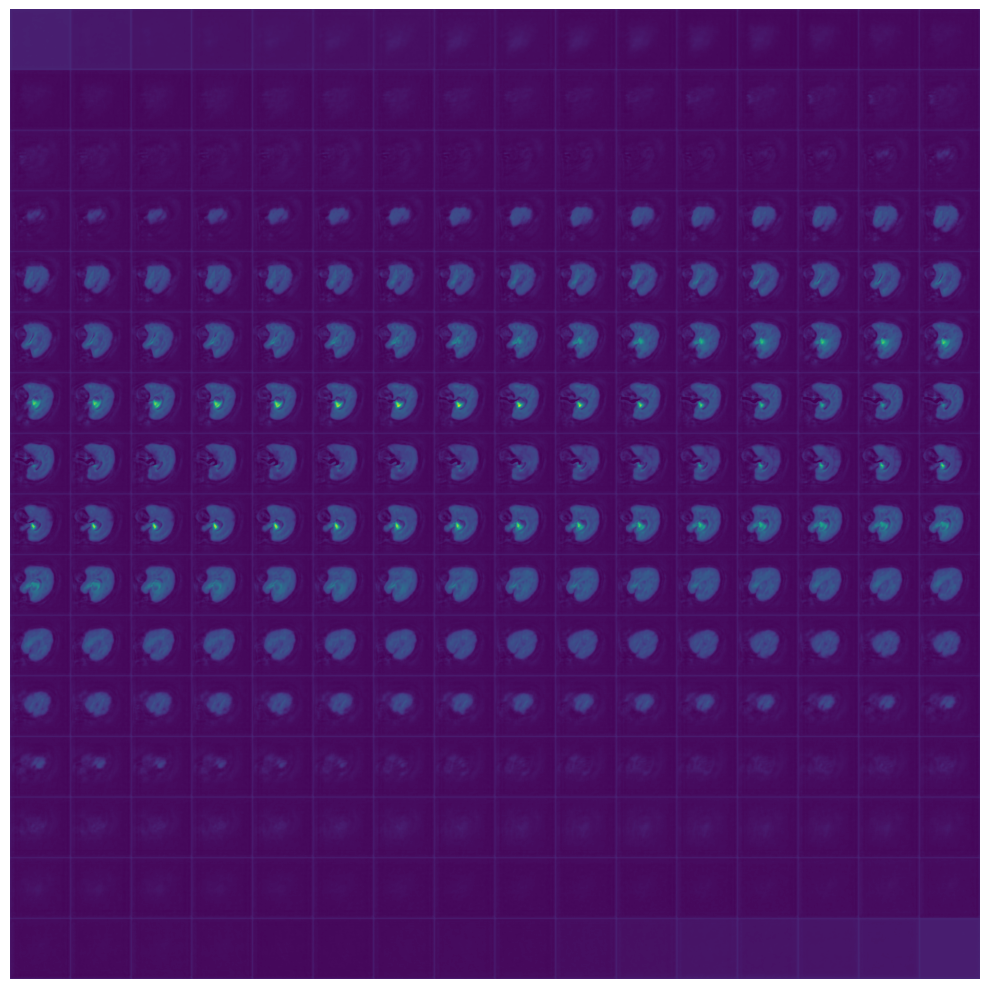

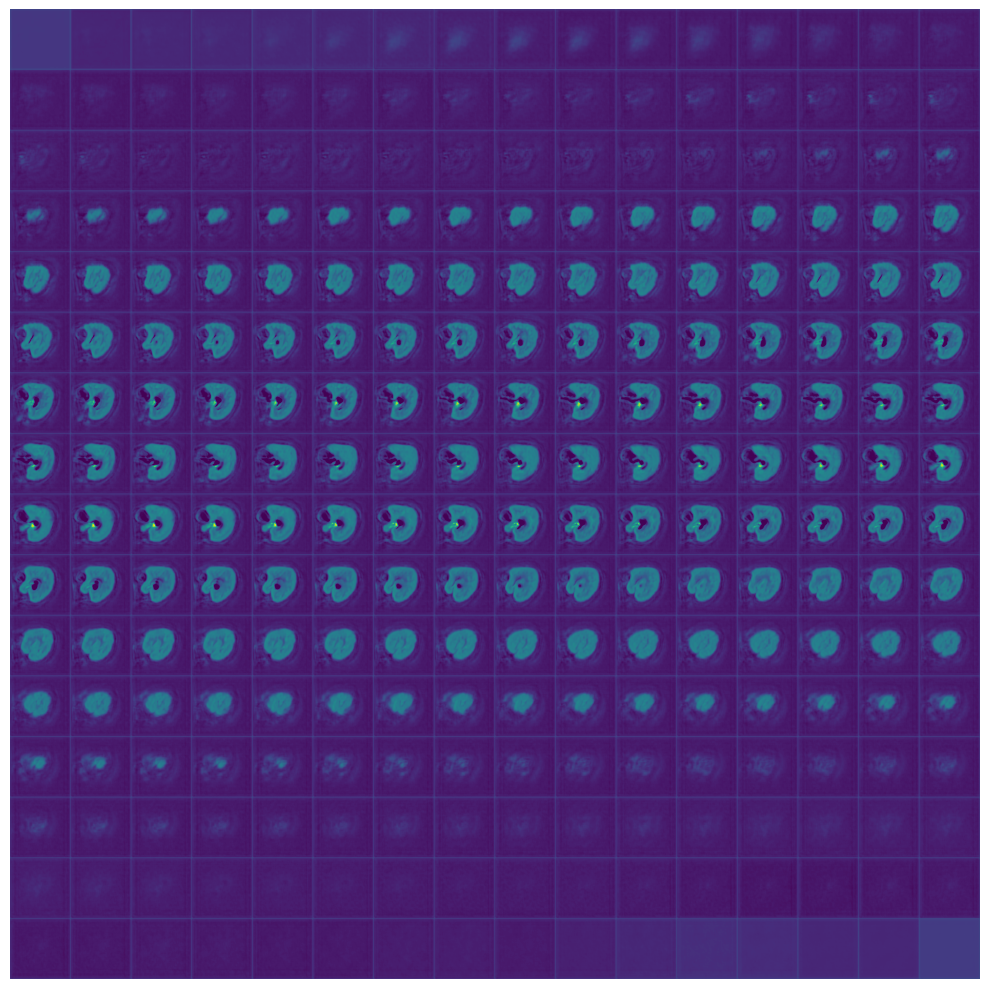

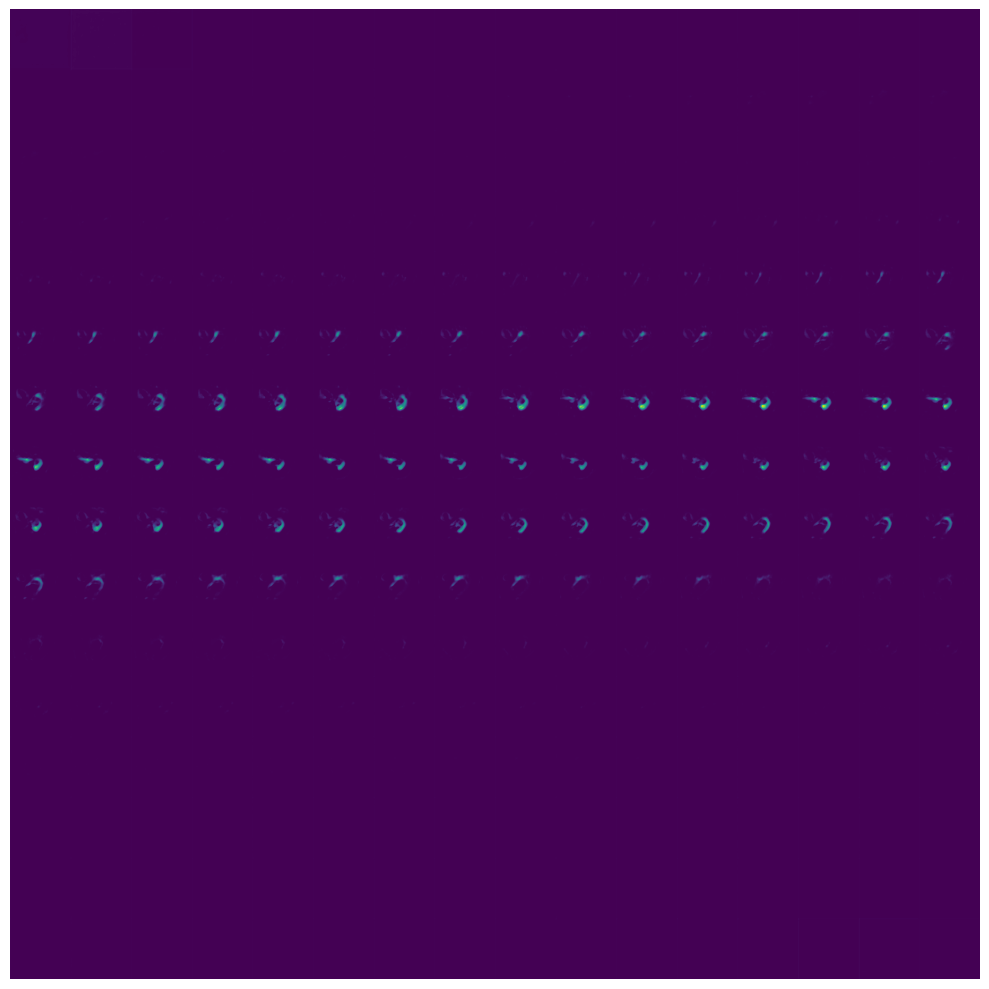

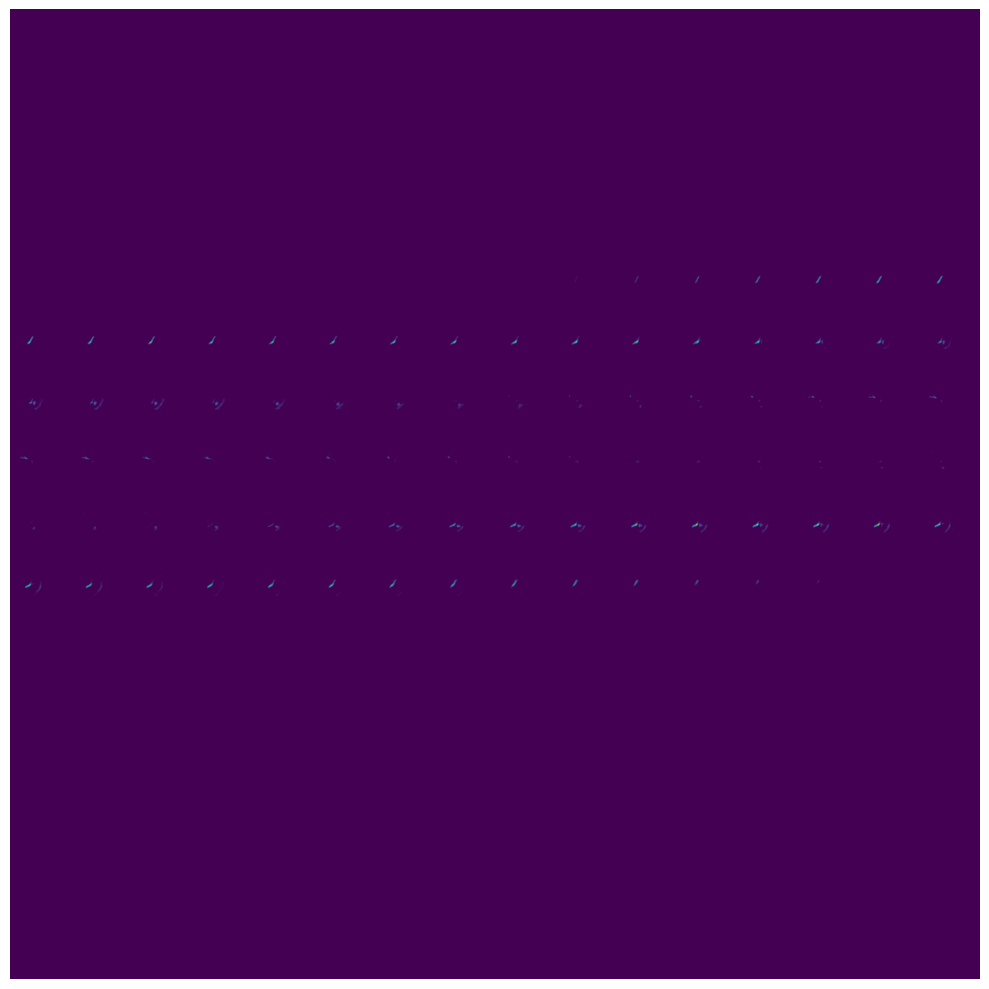

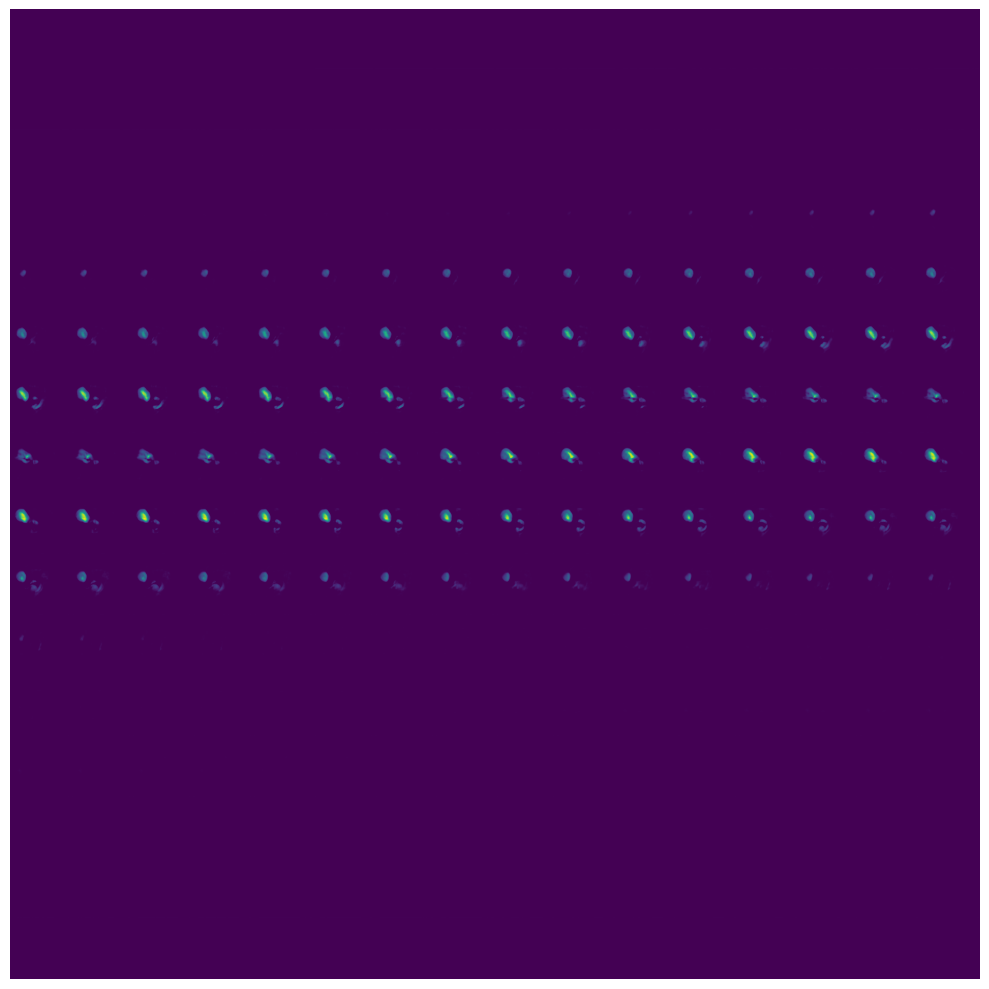

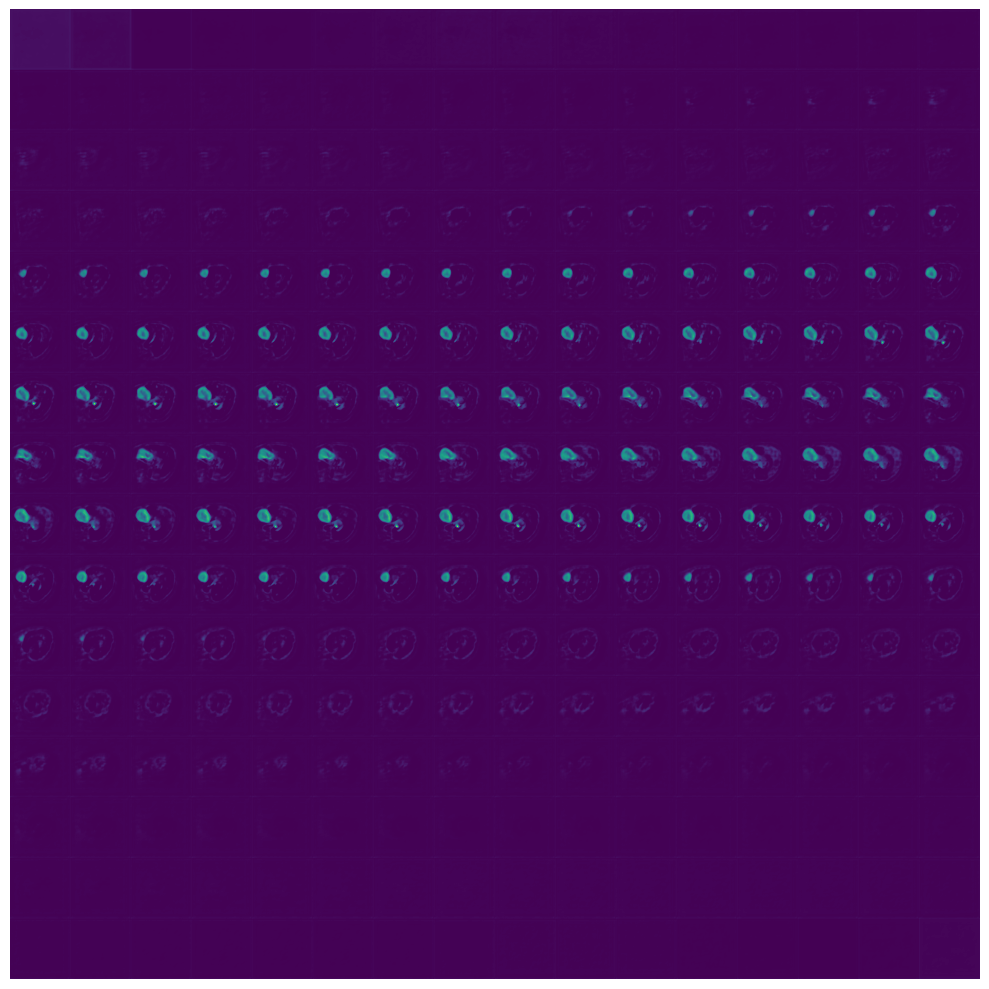

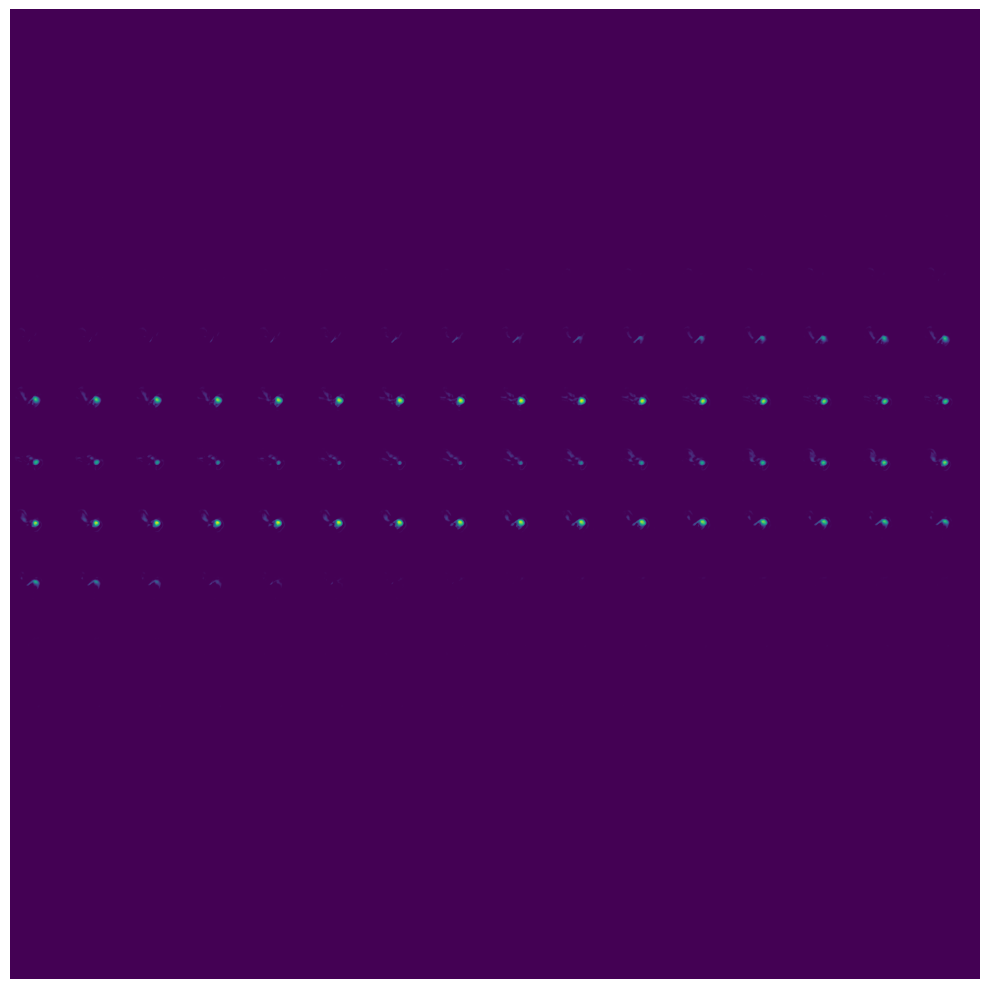

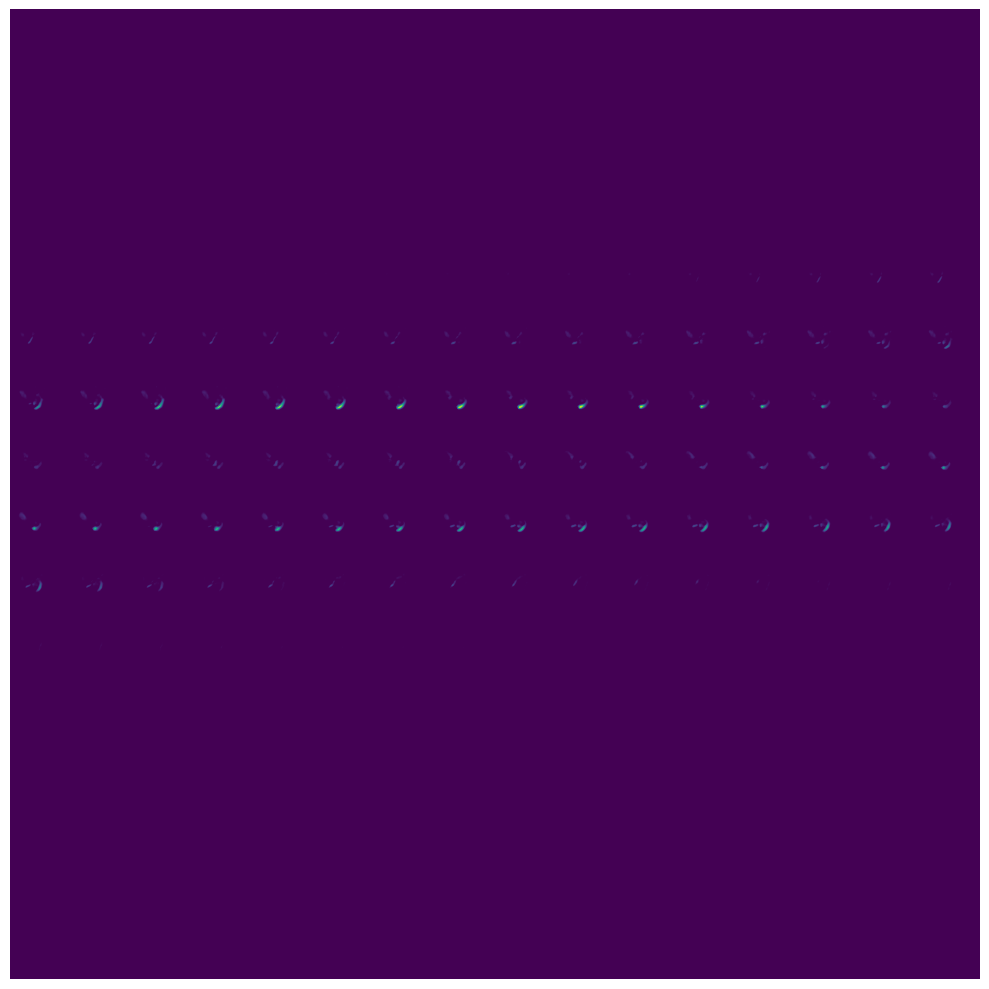

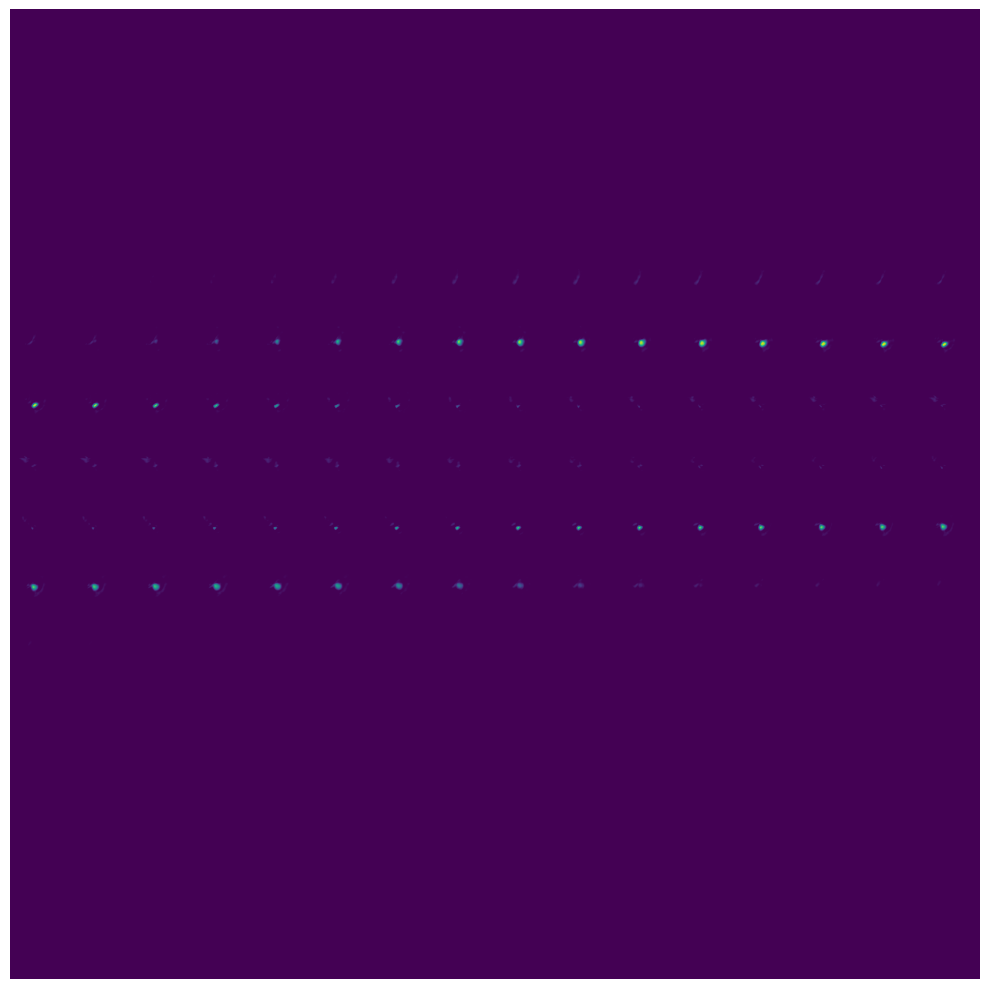

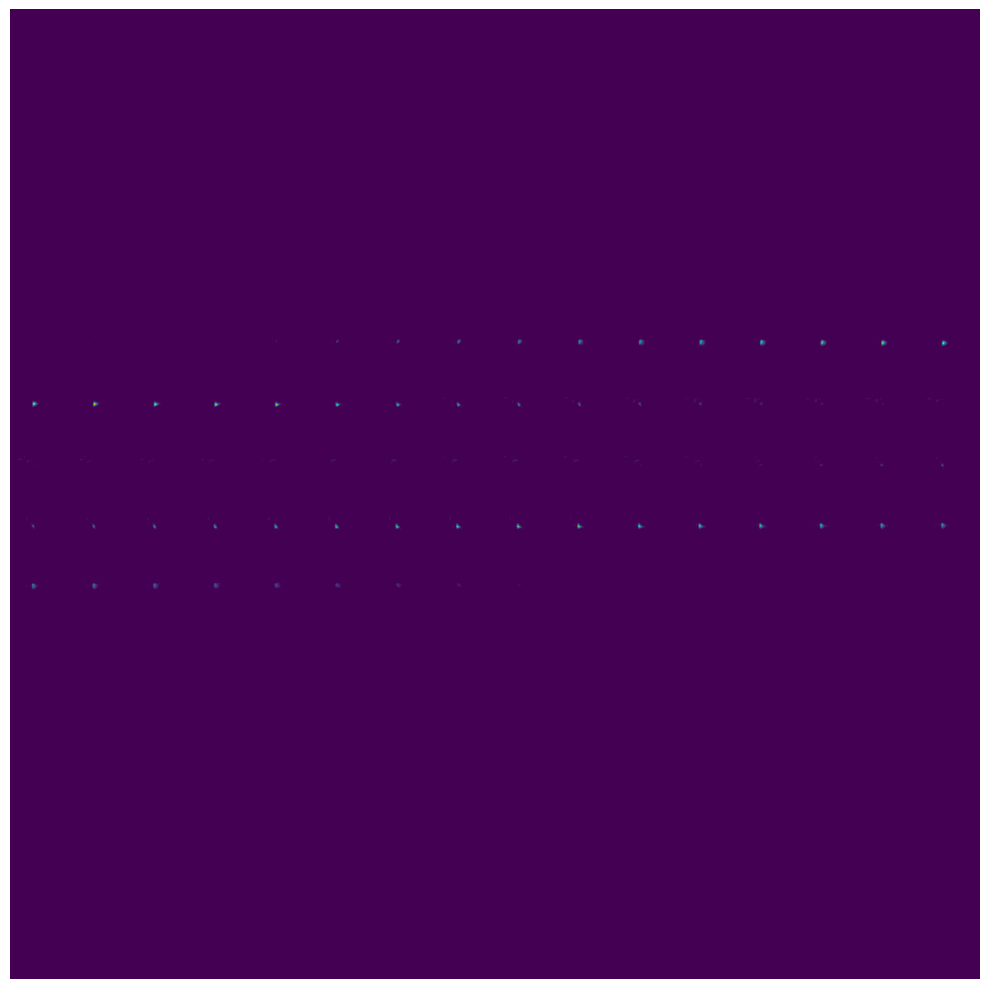

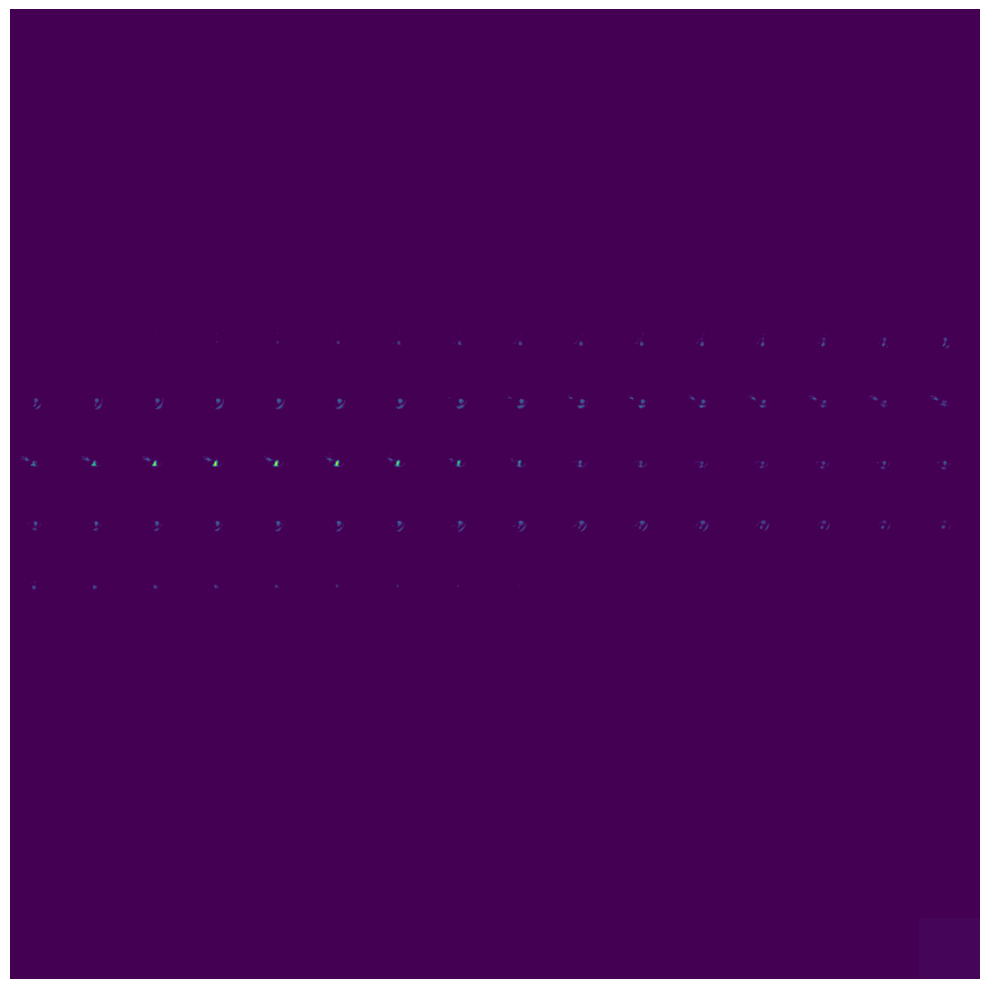

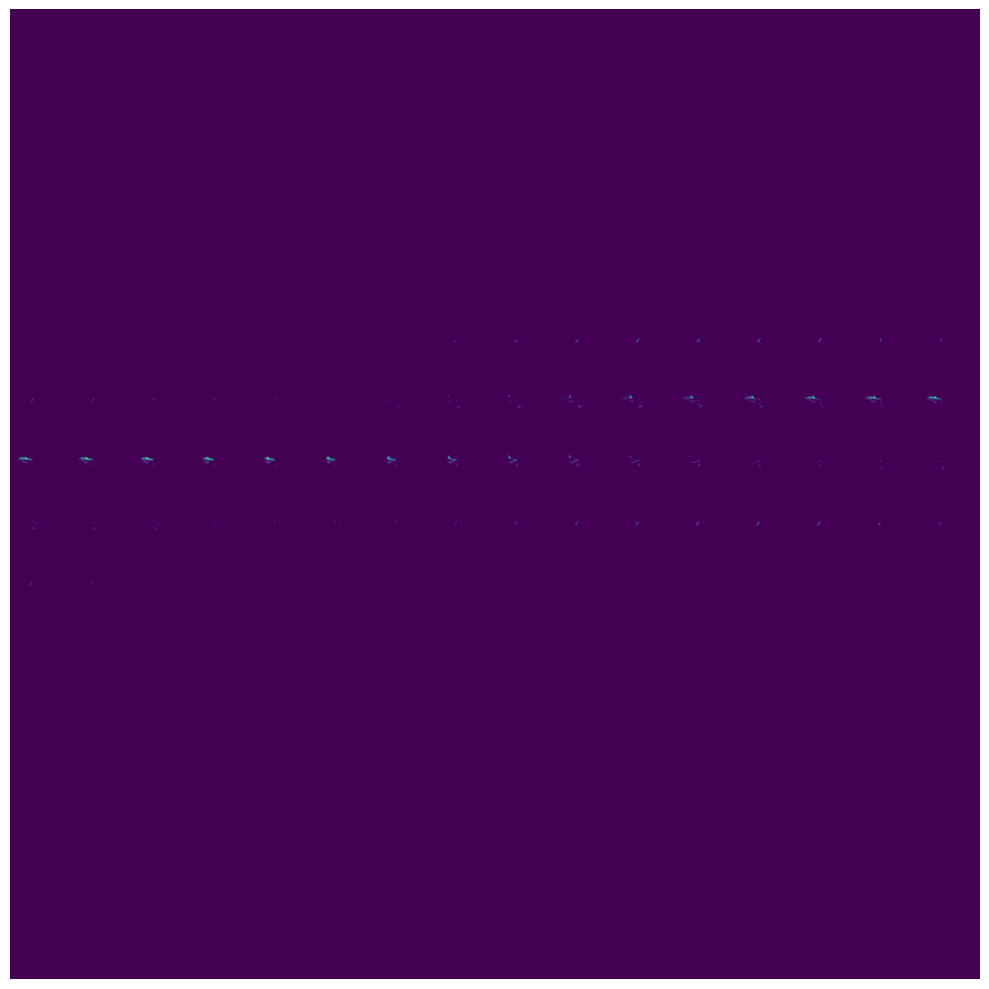

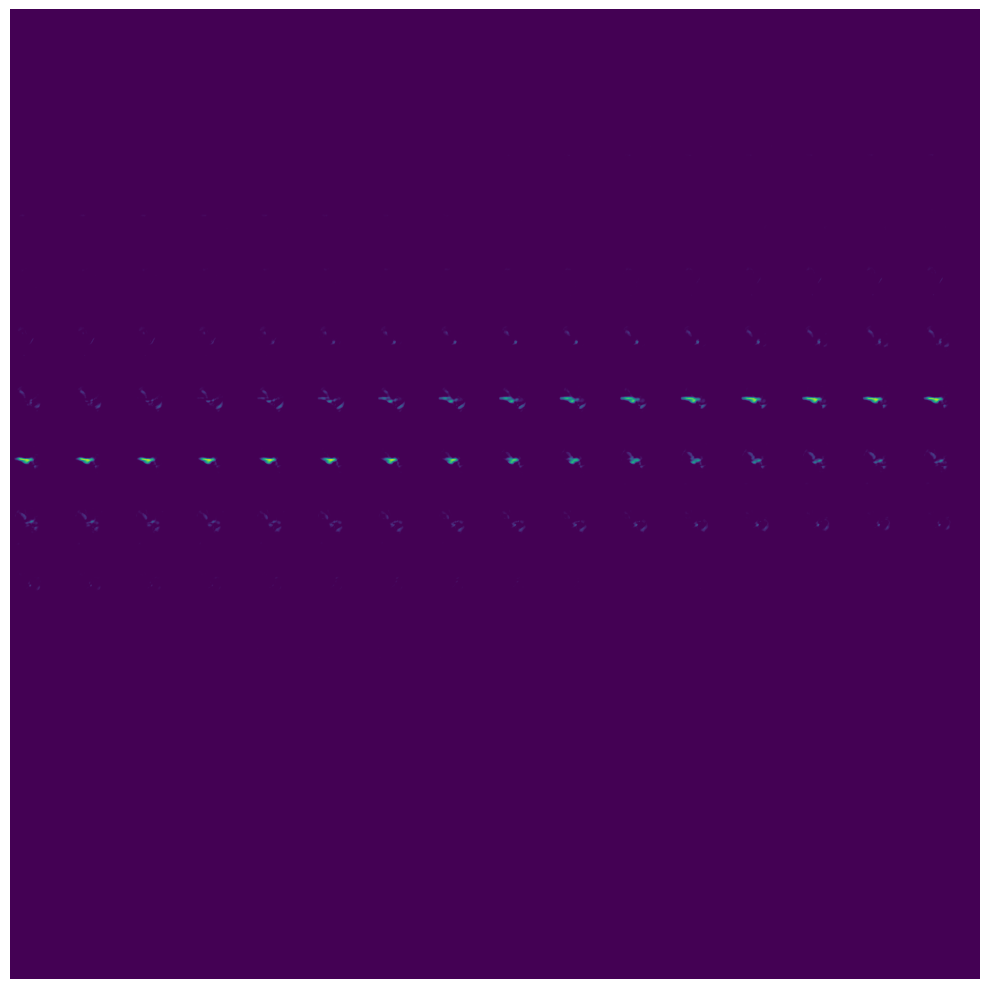

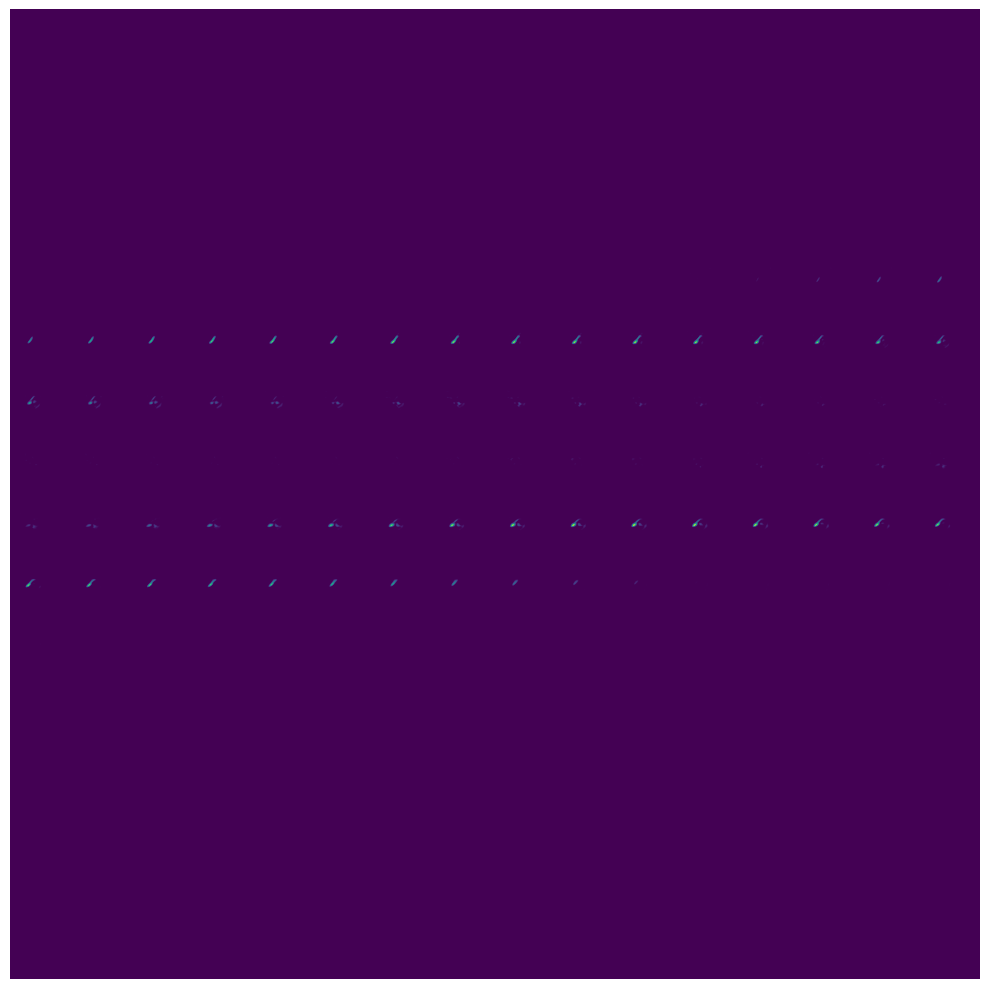

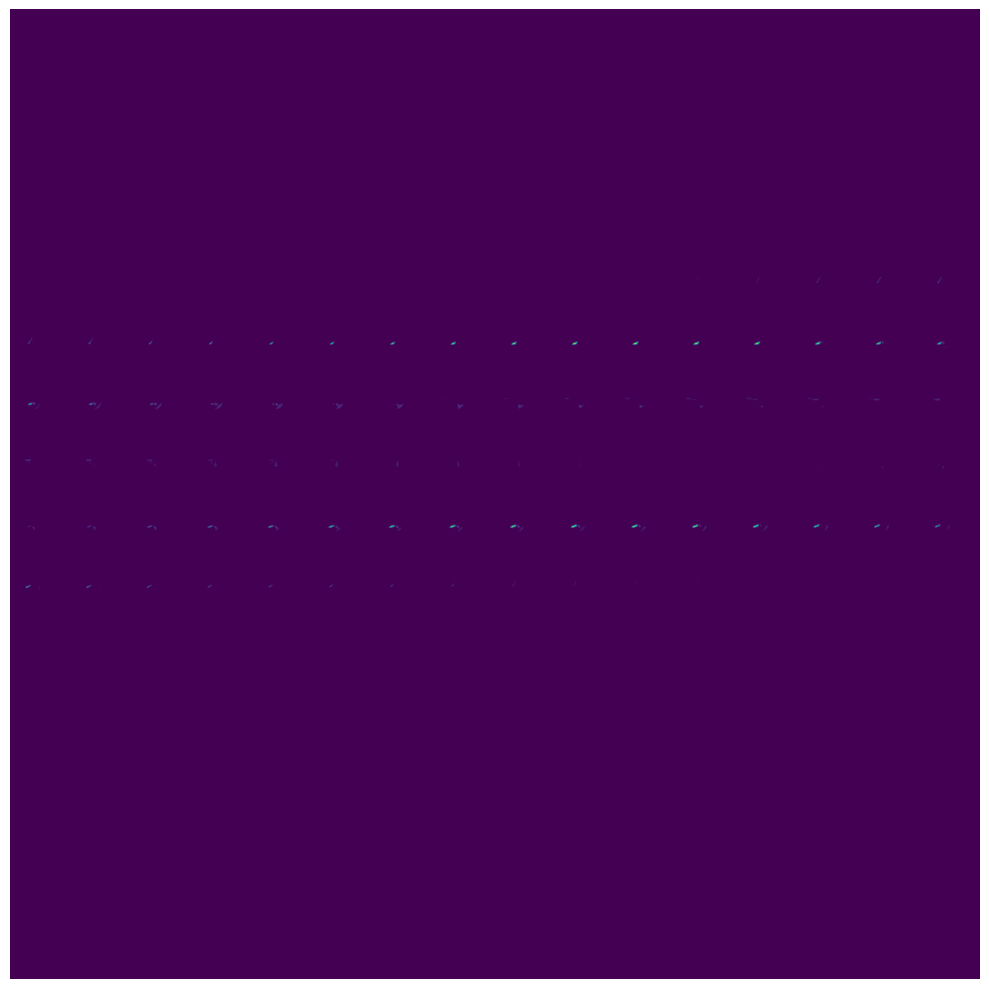

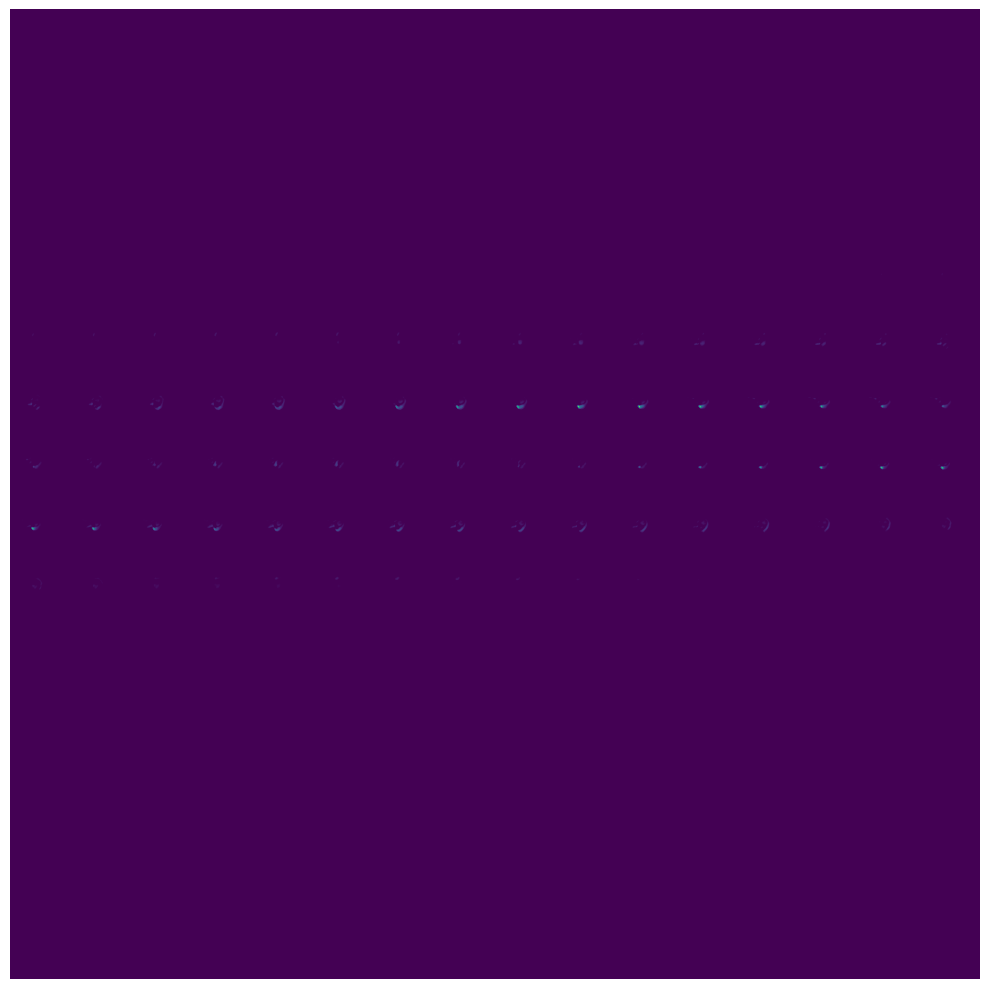

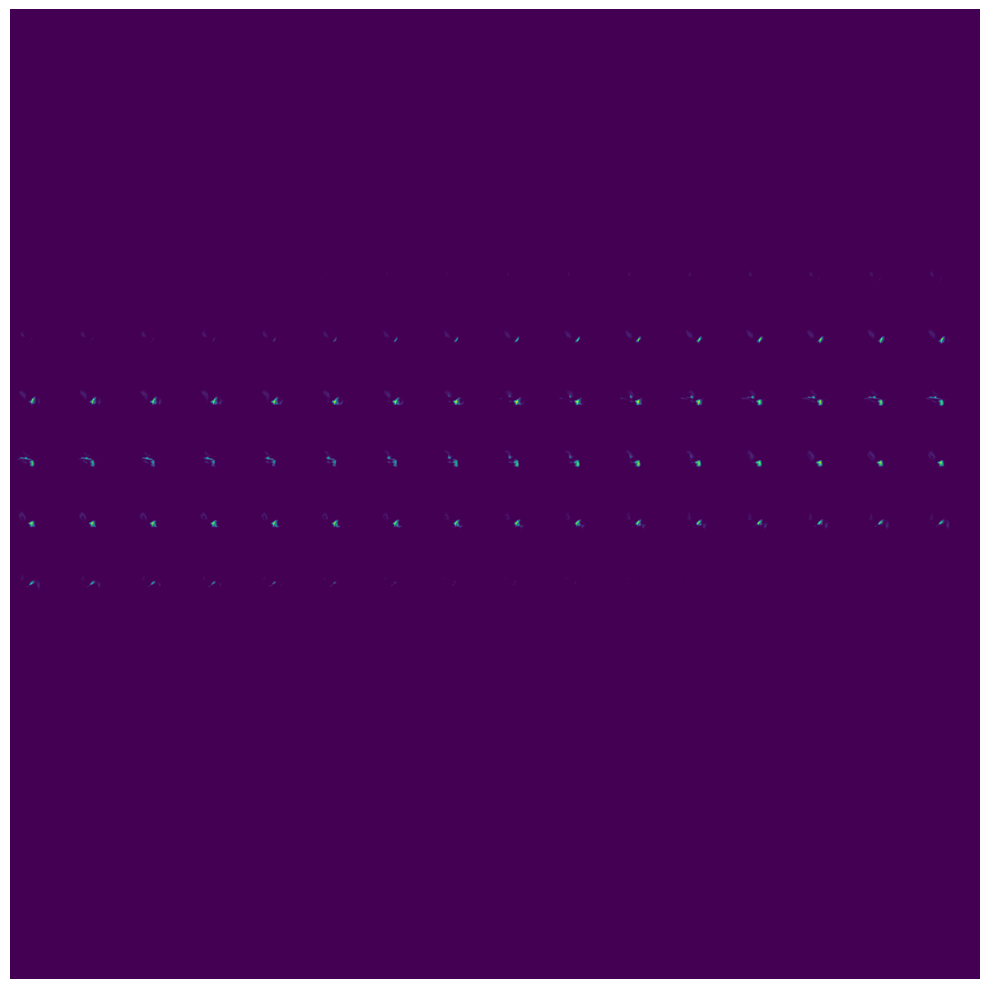

In [8]:
import numpy as np

img = np.load('test_input.npy')[0][0]
lab = np.load('test_label.npy')[0]
out = np.load('test_output.npy')[0]
print(out.shape)
plot(img)
plot(lab)
for _ in out:
    plot(_)

In [ ]:
from datetime import datetime
import threading
from typing import Dict
import os
import easybar
import shutil
import pickle
import time

from catalyst import dl, metrics, utils
from catalyst.data import BatchPrefetchLoaderWrapper
from catalyst.data.sampler import DistributedSamplerWrapper
from catalyst.dl import DataParallelEngine, DistributedDataParallelEngine
from catalyst.data.loader import ILoaderWrapper

import ipdb
import nibabel as nib
import numpy as np
from pymongo.errors import OperationFailure

import torch
from torch.optim.lr_scheduler import (
    MultiStepLR,
    OneCycleLR,
    CosineAnnealingLR,
    ChainedScheduler,
    CyclicLR,
    StepLR,
    ConstantLR,
)
from torch.utils.data import DataLoader, Dataset, DistributedSampler

from dice import faster_dice, DiceLoss
from meshnet import enMesh_checkpoint, enMesh
from mindfultensors.gencoords import CoordsGenerator
from mindfultensors.utils import (
    unit_interval_normalize,
    qnormalize,
    DBBatchSampler,
)

from mindfultensors.mongoloader import (
    create_client,
    collate_subcubes,
    mcollate,
    MongoDataset,
    MongoClient,
    mtransform,
)

# SEED = 0
# utils.set_global_seed(SEED)
# utils.prepare_cudnn(deterministic=False, benchmark=False) # crashes everything

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"
# os.environ["NCCL_SOCKET_IFNAME"] = "ib0"
# os.environ["NCCL_P2P_LEVEL"] = "NVL"

volume_shape = [256] * 3
MAXSHAPE = 300

LABELFIELD = "label"
DATAFIELD = "data"

n_classes = 18

MONGOHOST = "10.245.12.58"  # "arctrdcn018.rs.gsu.edu"
DBNAME = "babywire_test"
COLLECTION = "read"
INDEX_ID = "id"
config_file = "modelAE.json"


def merge_homologs(label, device):
    max_value = 31
    idx = torch.arange(max_value + 1, dtype=torch.long).to(device)
    idx[31] = 17
    idx[30] = 16
    idx[29] = 15
    idx[28] = 14
    idx[27] = 10
    idx[26] = 9
    idx[25] = 8
    idx[24] = 7
    idx[23] = 6
    idx[22] = 5
    idx[21] = 4
    idx[20] = 3
    idx[19] = 2
    idx[18] = 1
    # return the corresponding values from idx
    return idx[label.long()]


class WireMongoDataset(MongoDataset):
    def __init__(self, *args, keeptrying=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.keeptrying = keeptrying  # Initialize the keeptrying attribute

    def retry_on_eof_error(retry_count, verbose=False):
        def decorator(func):
            def wrapper(self, batch, *args, **kwargs):
                myException = Exception  # Default Exception if not overwritten
                for attempt in range(retry_count):
                    try:
                        return func(self, batch, *args, **kwargs)
                    except (
                        EOFError,
                        OperationFailure,
                    ) as e:  # Specifically catching EOFError
                        if self.keeptrying:
                            if verbose:
                                print(
                                    f"EOFError caught. Retrying {attempt+1}/{retry_count}"
                                )
                            time.sleep(1)
                            myException = e
                            continue
                        else:
                            raise e
                raise myException("Failed after multiple retries.")

            return wrapper

        return decorator

    @retry_on_eof_error(retry_count=3, verbose=True)
    def __getitem__(self, batch):
        # Directly use the parent class's __getitem__ method
        # The decorator will handle exceptions
        return super().__getitem__(batch)


# CustomRunner – PyTorch for-loop decomposition
# https://github.com/catalyst-team/catalyst#minimal-examples
class CustomRunner(dl.Runner):
    def __init__(
        self,
        logdir: str,
        wandb_project: str,
        wandb_experiment: str,
        model_path: str,
        n_channels: int,
        n_classes: int,
        n_epochs: int,
        optimize_inline: bool,        validation_percent: float,
        onecycle_lr: float,
        rmsprop_lr: float,
        num_subcubes: int,
        num_volumes: int,
        client_creator,
        off_brain_weight: float,
        prefetches=8,
        volume_shape=[256] * 3,
        subvolume_shape=[256] * 3,
        db_host=MONGOHOST,
        db_name=DBNAME,
        db_collection=COLLECTION,
    ):
        super().__init__()
        self._logdir = logdir
        self.wandb_project = wandb_project
        self.wandb_experiment = wandb_experiment
        self.model_path = model_path
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.optimize_inline = optimize_inline
        self.onecycle_lr = onecycle_lr
        self.rmsprop_lr = rmsprop_lr
        self.prefetches = prefetches
        self.db_host = db_host
        self.db_name = db_name
        self.db_collection = db_collection
        self.shape = subvolume_shape[0]
        self.num_subcubes = num_subcubes
        self.num_volumes = num_volumes
        self.n_epochs = n_epochs
        self.off_brain_weight = off_brain_weight
        self.client_creator = client_creator
        self.funcs = None
        self.collate = None

    def get_engine(self):
        if torch.cuda.device_count() > 1:
            return dl.DistributedDataParallelEngine(
                # mixed_precision='fp16',
                # ddp_kwargs={"find_unused_parameters": True, "backend": "nccl"}
                process_group_kwargs={"backend": "nccl"}
            )
        else:
            return dl.GPUEngine()

    def get_loggers(self):
        return {
            "console": dl.ConsoleLogger(),
            "csv": dl.CSVLogger(logdir=self._logdir),
            # "tensorboard": dl.TensorboardLogger(logdir=self._logdir,
            #                                     log_batch_metrics=True),
            "wandb": dl.WandbLogger(
                project=self.wandb_project,
                name=self.wandb_experiment,
                log_batch_metrics=True,
            ),
        }

    @property
    def stages(self):
        return ["train"]

    @property
    def num_epochs(self) -> int:
        return self.n_epochs

    @property
    def seed(self) -> int:
        """Experiment's seed for reproducibility."""
        random_data = os.urandom(4)
        SEED = int.from_bytes(random_data, byteorder="big")
        utils.set_global_seed(SEED)
        return SEED

    def get_stage_len(self) -> int:
        return self.n_epochs

    def get_loaders(self):
        self.funcs = {
            "createclient": self.client_creator.create_client,
            "mycollate": self.client_creator.mycollate,
            "mycollate_full": self.client_creator.mycollate_full,
            "mytransform": self.client_creator.mytransform,
        }

        self.collate = (
            self.funcs["mycollate_full"]
            if self.shape == 256
            else self.funcs["mycollate"]
        )

        client = MongoClient("mongodb://" + self.db_host + ":27017")
        db = client[self.db_name]
        posts = db[self.db_collection + ".bin"]
        num_examples = int(posts.find_one(sort=[(INDEX_ID, -1)])[INDEX_ID] + 1)

        tdataset = WireMongoDataset(
            range(num_examples),
            self.funcs["mytransform"],
            None,
            (DATAFIELD, LABELFIELD),
            normalize=qnormalize,
            id=INDEX_ID,
        )

        tsampler = (
            DistributedSamplerWrapper(
                DBBatchSampler(tdataset, batch_size=self.num_volumes)
            )
            if self.engine.is_ddp
            else DBBatchSampler(tdataset, batch_size=self.num_volumes)
        )

        tdataloader = BatchPrefetchLoaderWrapper(
            DataLoader(
                tdataset,
                sampler=tsampler,
                collate_fn=self.collate,
                pin_memory=True,
                worker_init_fn=self.funcs["createclient"],
                persistent_workers=True,
                prefetch_factor=3,
                num_workers=self.prefetches,
            ),
            num_prefetches=self.prefetches,
        )

        return {"train": tdataloader}

    def get_model(self):
        if self.shape > MAXSHAPE:
            model = enMesh(
                in_channels=1,
                n_classes=self.n_classes,
                channels=self.n_channels,
                config_file=config_file,
                optimize_inline=self.optimize_inline,
            )
        else:
            model = enMesh_checkpoint(
                in_channels=1,
                n_classes=self.n_classes,
                channels=self.n_channels,
                config_file=config_file,
            )
        return model

    def get_criterion(self):
        class_weight = torch.FloatTensor(
            [self.off_brain_weight] + [1.0] * (self.n_classes - 1)
        ).to(self.engine.device)
        ce_criterion = torch.nn.CrossEntropyLoss(
            weight=class_weight, label_smoothing=0.01
        )
        dice_criterion = DiceLoss()

        def combined_loss(output, target):
            ce_loss = ce_criterion(output, target)
            dice_loss = dice_criterion(output, target)
            return 0.7 * ce_loss + 0.3 * dice_loss

        return combined_loss

    def get_criterion_(self):
        class_weight = torch.FloatTensor(
            [self.off_brain_weight] + [1.0] * (self.n_classes - 1)
        ).to(self.engine.device)
        criterion = torch.nn.CrossEntropyLoss(
            weight=class_weight, label_smoothing=0.01
        )
        # criterion = DiceLoss()
        return criterion

    def get_optimizer(self, model):
        # optimizer = torch.optim.RMSprop(model.parameters(), lr=self.rmsprop_lr)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.rmsprop_lr)
        return optimizer

    def get_scheduler(self, optimizer):
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.onecycle_lr,
            div_factor=100,
            pct_start=0.2,
            epochs=self.num_epochs,
            steps_per_epoch=len(self.loaders["train"]),
        )
        return scheduler

    def get_callbacks(self):
        checkpoint_params = {"save_best": True, "metric_key": "macro_dice"}
        if self.model_path:
            checkpoint_params.update({"resume_model": self.model_path})
        return {
            "checkpoint": dl.CheckpointCallback(
                self._logdir, **checkpoint_params
            ),
            "tqdm": dl.TqdmCallback(),
        }

    def on_loader_start(self, runner):
        """
        Calls runner methods when the dataloader begins and adds
        metrics for loss and macro_dice
        """
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveValueMetric(compute_on_call=False)
            for key in ["loss", "macro_dice", "learning rate"]
        }

    def on_loader_end(self, runner):
        """
        Calls runner methods when a dataloader finishes running and updates
        metrics
        """
        for key in ["loss", "macro_dice", "learning rate"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

    # model train/valid step
    def handle_batch(self, batch):
        # unpack the batch
        sample, label = batch
        label = merge_homologs(label, self.engine.device)
        y_hat = self.model.forward(sample)
        np.save("test_label.npy", label.cpu().numpy())
        np.save("test_input.npy", sample.detach().cpu().numpy())
        np.save("test_output.npy", y_hat.detach().cpu().numpy())

class ClientCreator:
    def __init__(self, dbname, mongohost, volume_shape=[256] * 3):
        self.dbname = dbname
        self.mongohost = mongohost
        self.volume_shape = volume_shape
        self.subvolume_shape = None
        self.collection = None
        self.num_subcubes = None

    def set_shape(self, shape):
        self.subvolume_shape = shape
        self.coord_generator = CoordsGenerator(
            self.volume_shape, self.subvolume_shape
        )

    def set_collection(self, collection):
        self.collection = collection

    def set_num_subcubes(self, num_subcubes):
        self.num_subcubes = num_subcubes

    def create_client(self, x):
        return create_client(
            x,
            dbname=self.dbname,
            colname=self.collection,
            mongohost=self.mongohost,
        )

    def mycollate(self, x):
        return collate_subcubes(
            x,
            self.coord_generator,
            samples=self.num_subcubes,
        )

    def mycollate_full(self, x):
        return mcollate(x)

    def mytransform(self, x):
        return mtransform(x)


def assert_equal_length(*args):
    assert all(
        len(arg) == len(args[0]) for arg in args
    ), "Not all parameter lists have the same length!"


if __name__ == "__main__":
    # hparams
    validation_percent = 0.1
    optimize_inline = False

    model_channels = 30
    model_label = "_ss"

    model_path = f"./logs/tmp/curriculum_enmesh_{model_channels}channels_ss/model.last.pth"
    #model_path = ""
    logdir = f"./logs/tmp/curriculum_enmesh_{model_channels}channels_ss/"
    wandb_project = f"curriculum_{model_channels}_ss"

    client_creator = ClientCreator(DBNAME, MONGOHOST)

    # set up parameters of your experiment
    experiment_count = 1

    cubesizes   = [256] * experiment_count
    numcubes    = [4] * experiment_count
    numvolumes  = [1] * experiment_count
    weights     = [1] * experiment_count  # weights for the 0-class
    collections = ["read"] * experiment_count
    epochs      = [1] * experiment_count
    prefetches  = [1] * experiment_count
    attenuates  = [1] * experiment_count

    assert_equal_length(
        cubesizes,
        numcubes,
        numvolumes,
        weights,
        collections,
        epochs,
        prefetches,
        attenuates,
    )

    start_experiment = 0
    for experiment in range(len(cubesizes)):
        COLLECTION = collections[experiment]
        num_subcubes = numcubes[experiment]
        num_volumes = numvolumes[experiment]

        off_brain_weight = weights[experiment]
        subvolume_shape = [cubesizes[experiment]] * 3
        onecycle_lr = rmsprop_lr = (
            attenuates[experiment] * 0.05 * 8 * num_subcubes * num_volumes / 256
        )
        n_epochs = epochs[experiment]
        n_fetch = prefetches[experiment]
        wandb_experiment = (
            f"{start_experiment + experiment:02} cube "
            + str(subvolume_shape[0])
            + " "
            + COLLECTION
            + model_label
        )

        # Set database parameters
        client_creator.set_collection(COLLECTION)
        client_creator.set_num_subcubes(num_subcubes)
        client_creator.set_shape(subvolume_shape)

        runner = CustomRunner(
            logdir=logdir,
            wandb_project=wandb_project,
            wandb_experiment=wandb_experiment,
            model_path=model_path,
            n_channels=model_channels,
            n_classes=n_classes,
            n_epochs=n_epochs,
            optimize_inline=optimize_inline,
            validation_percent=validation_percent,
            onecycle_lr=onecycle_lr,
            rmsprop_lr=rmsprop_lr,
            num_subcubes=num_subcubes,
            num_volumes=num_volumes,
            client_creator=client_creator,
            off_brain_weight=off_brain_weight,
            prefetches=n_fetch,
            db_collection=COLLECTION,
            subvolume_shape=subvolume_shape,
        )
        runner.run()